<a href="https://colab.research.google.com/github/jethompson023/Kettering-Senior-Thesis-Project/blob/main/Thesis_MachineLearning_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
#Imports for our Script
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from datetime import *

In [96]:
#Add google authentication ok
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

#Import the data from the Google Sheet
workbook = gc.open_by_key('1mjE530k7fYKkPh9VPcqfElrrzMkw59uUTPQ34VWH0wA')
worksheet = workbook.worksheet('POU')

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
df = pd.DataFrame.from_records(rows)

#Next we are going to format the rows to allow for the data to get into a data frame
new_header = df.iloc[0] #grab the first row for the header
df = df[0:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df  = df.drop(labels=0, axis=0)

In [110]:
ml = pd.DataFrame(columns=['date', 'qty'])
ml['date'] = df['Date Found']
ml['qty'] = df['Qty']
ml = ml.set_index(ml['date'])
ml = ml.drop(['date'],axis=1)

In [111]:
ml.head()

,qty
date,
05/19/2022,2
07/25/2022,1
07/25/2022,1
07/28/2022,1
07/29/2022,1


In [54]:
len(df) / 2

16958.0

In [117]:
#train = ml.iloc[:16958]
#test = ml.iloc[16958:]
train = ml.iloc[:169]
test = ml.iloc[:169]

In [118]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [119]:
ml.head(),ml.tail()

(           qty
 date          
 05/19/2022   2
 07/25/2022   1
 07/25/2022   1
 07/28/2022   1
 07/29/2022   1,            qty
 date          
 09/13/2022   1
 09/13/2022   1
 09/13/2022   1
 09/13/2022   1
 09/13/2022   1)

In [120]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [121]:
scaled_train[:10]

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [122]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [123]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [124]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1. 0. 0.]
Predict this y: 
 [[0.]]


In [125]:

# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [127]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [128]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [129]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
157/157 [==============================] - 3s 7ms/step - loss: 0.0126
Epoch 2/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0125
Epoch 3/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0121
Epoch 4/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0121
Epoch 5/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0117
Epoch 6/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0112
Epoch 7/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0111
Epoch 8/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 9/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0099
Epoch 10/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 11/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0092
Epoch 12/50
157/157 [==============================] - 1s 7ms/step - loss: 0.0083
Epoch 13/50
157/157 [====

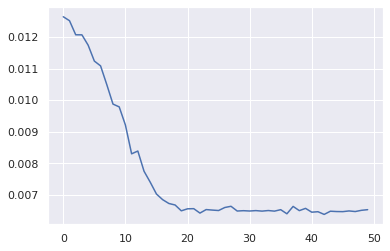

In [130]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [131]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 416ms/step


array([[-0.16331612]], dtype=float32)

In [132]:
scaled_test[0]

array([1.])

In [133]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [134]:
test_predictions

[array([-0.16331612], dtype=float32),
 array([-0.1467113], dtype=float32),
 array([-0.10869737], dtype=float32),
 array([-0.07621565], dtype=float32),
 array([-0.05161393], dtype=float32),
 array([-0.03383277], dtype=float32),
 array([-0.02047316], dtype=float32),
 array([-0.01048167], dtype=float32),
 array([-0.00296878], dtype=float32),
 array([0.0029139], dtype=float32),
 array([0.00471134], dtype=float32),
 array([0.01571376], dtype=float32),
 array([0.01901212], dtype=float32),
 array([0.01878735], dtype=float32),
 array([0.01825373], dtype=float32),
 array([0.01783251], dtype=float32),
 array([0.01753522], dtype=float32),
 array([0.01734121], dtype=float32),
 array([0.01722171], dtype=float32),
 array([0.01714959], dtype=float32),
 array([0.01710733], dtype=float32),
 array([0.01708601], dtype=float32),
 array([0.01708052], dtype=float32),
 array([0.01706521], dtype=float32),
 array([0.01705696], dtype=float32),
 array([0.01706037], dtype=float32),
 array([0.01706608], dtype=floa

In [136]:
test['predictions'] = test_predictions
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,qty,predictions
date,,
05/19/2022,2,[-0.16331612]
07/25/2022,1,[-0.1467113]
07/25/2022,1,[-0.10869737]
07/28/2022,1,[-0.07621565]
07/29/2022,1,[-0.05161393]
